##### <h1 id="aa" align="center" style="color:black;background:#ffcc01;padding:18px;border-radius:50px"> КЛАСТЕРИЗАЦИЯ ПОКЕМОНОВ </h1> 

### Подключение модулей

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
import scipy.cluster.hierarchy as sch


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Загрузка данных

In [86]:
df = pd.read_csv('pokemon.csv')

In [87]:
df.head(10)

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
0,Bulbasaur,318,45,49,49,65,65,45
1,Ivysaur,405,60,62,63,80,80,60
2,Venusaur,525,80,82,83,100,100,80
3,Mega Venusaur,625,80,100,123,122,120,80
4,Charmander,309,39,52,43,60,50,65
5,Charmeleon,405,58,64,58,80,65,80
6,Charizard,534,78,84,78,109,85,100
7,Mega Charizard,634,78,130,111,130,85,100
8,Mega Charizard X,634,78,104,78,159,115,100
9,Squirtle,314,44,48,65,50,64,43


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1045 non-null   object
 1   Total       1045 non-null   int64 
 2   HP          1045 non-null   int64 
 3   Attack      1045 non-null   int64 
 4   Defence     1045 non-null   int64 
 5   Sp_attack   1045 non-null   int64 
 6   Sp_defence  1045 non-null   int64 
 7   Speed       1045 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 65.4+ KB


In [89]:
df.shape

(1045, 8)

In [90]:
df.describe()

,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,439.314833,70.067943,80.466986,74.661244,73.022010,72.288995,68.807656
std,121.970701,26.671411,32.413665,31.237903,32.724797,28.074148,30.210094
min,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,330.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000
50%,458.000000,68.000000,77.000000,70.000000,65.000000,70.000000,65.000000
75%,515.000000,82.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,1125.000000,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


In [91]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Total,1045.0,439.314833,121.970701,175.0,330.0,458.0,515.0,1125.0
HP,1045.0,70.067943,26.671411,1.0,50.0,68.0,82.0,255.0
Attack,1045.0,80.466986,32.413665,5.0,55.0,77.0,100.0,190.0
Defence,1045.0,74.661244,31.237903,5.0,50.0,70.0,90.0,250.0
Sp_attack,1045.0,73.022010,32.724797,10.0,50.0,65.0,95.0,194.0
Sp_defence,1045.0,72.288995,28.074148,20.0,50.0,70.0,90.0,250.0
Speed,1045.0,68.807656,30.210094,5.0,45.0,65.0,90.0,200.0


### Описание данных

##### Признаки:
- **Name** - Имя каждого покемона.
- **Total** - Сумма всех статистик, которые идут после этого, общее руководство по тому, насколько силен покемон.
- **HP** - Хит-пойнты, или здоровье, определяют, сколько урона может выдержать покемон, прежде чем потеряет сознание.
- **Attack** - Базовый модификатор для обычных атак (например, Царапина, Удар).
- **Defence** - Базовое сопротивление урону от обычных атак.
- **Sp_attack** - специальная атака, базовый модификатор для специальных атак (например, огненный взрыв, луч пузыря).
- **Sp_defence** - базовое сопротивление урону от специальных атак.
- **Speed** - Определяет, какой покемон атакует первым в каждом раунде.

In [92]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1045 non-null   object
 1   Total       1045 non-null   int64 
 2   HP          1045 non-null   int64 
 3   Attack      1045 non-null   int64 
 4   Defence     1045 non-null   int64 
 5   Sp_attack   1045 non-null   int64 
 6   Sp_defence  1045 non-null   int64 
 7   Speed       1045 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 65.4+ KB


In [93]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,1045,1035,Mega Rotom X,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total,1045.0,NaN,NaN,NaN,439.314833,121.970701,175.0,330.0,458.0,515.0,1125.0
HP,1045.0,NaN,NaN,NaN,70.067943,26.671411,1.0,50.0,68.0,82.0,255.0
Attack,1045.0,NaN,NaN,NaN,80.466986,32.413665,5.0,55.0,77.0,100.0,190.0
Defence,1045.0,NaN,NaN,NaN,74.661244,31.237903,5.0,50.0,70.0,90.0,250.0
Sp_attack,1045.0,NaN,NaN,NaN,73.02201,32.724797,10.0,50.0,65.0,95.0,194.0
Sp_defence,1045.0,NaN,NaN,NaN,72.288995,28.074148,20.0,50.0,70.0,90.0,250.0
Speed,1045.0,NaN,NaN,NaN,68.807656,30.210094,5.0,45.0,65.0,90.0,200.0


In [94]:
df.duplicated().sum()

np.int64(5)

In [95]:
df.isna().sum()

Name          0
Total         0
HP            0
Attack        0
Defence       0
Sp_attack     0
Sp_defence    0
Speed         0
dtype: int64

##### Вывод

В данном датасете отсутствуют пропущенные значения, но присутствуют повторяющиеся записи в столбце "Name".

In [96]:
df[df.duplicated(keep=False)]

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
420,Mega Castform X,420,70,70,70,70,70,70
421,Mega Castform X,420,70,70,70,70,70,70
571,Mega Rotom X,520,50,65,107,105,107,86
572,Mega Rotom X,520,50,65,107,105,107,86
573,Mega Rotom X,520,50,65,107,105,107,86
574,Mega Rotom X,520,50,65,107,105,107,86
868,Mega Oricorio X,476,75,70,70,98,70,93
869,Mega Oricorio X,476,75,70,70,98,70,93


In [97]:
df.drop_duplicates() # Удаляем дубликаты

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
0,Bulbasaur,318,45,49,49,65,65,45
1,Ivysaur,405,60,62,63,80,80,60
2,Venusaur,525,80,82,83,100,100,80
3,Mega Venusaur,625,80,100,123,122,120,80
4,Charmander,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...
1040,Glastrier,580,100,145,130,65,110,30
1041,Spectrier,580,100,65,60,145,80,130
1042,Calyrex,500,100,80,80,80,80,80
1043,Mega Calyrex,680,100,165,150,85,130,50


In [98]:
df[df.duplicated(keep=False)]

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
420,Mega Castform X,420,70,70,70,70,70,70
421,Mega Castform X,420,70,70,70,70,70,70
571,Mega Rotom X,520,50,65,107,105,107,86
572,Mega Rotom X,520,50,65,107,105,107,86
573,Mega Rotom X,520,50,65,107,105,107,86
574,Mega Rotom X,520,50,65,107,105,107,86
868,Mega Oricorio X,476,75,70,70,98,70,93
869,Mega Oricorio X,476,75,70,70,98,70,93


In [99]:
df.duplicated().sum()

np.int64(5)

In [103]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0]

In [ ]:
# plt.figure(figsize = (18,7))
# sns.heatmap(X.corr(), cmap = sns.color_palette("flare", as_cmap=True), annot = True, vmax = 1.6);
# plt.xticks(rotation=50, ha='right');

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

<Figure size 1800x700 with 0 Axes>

## Распределение данных

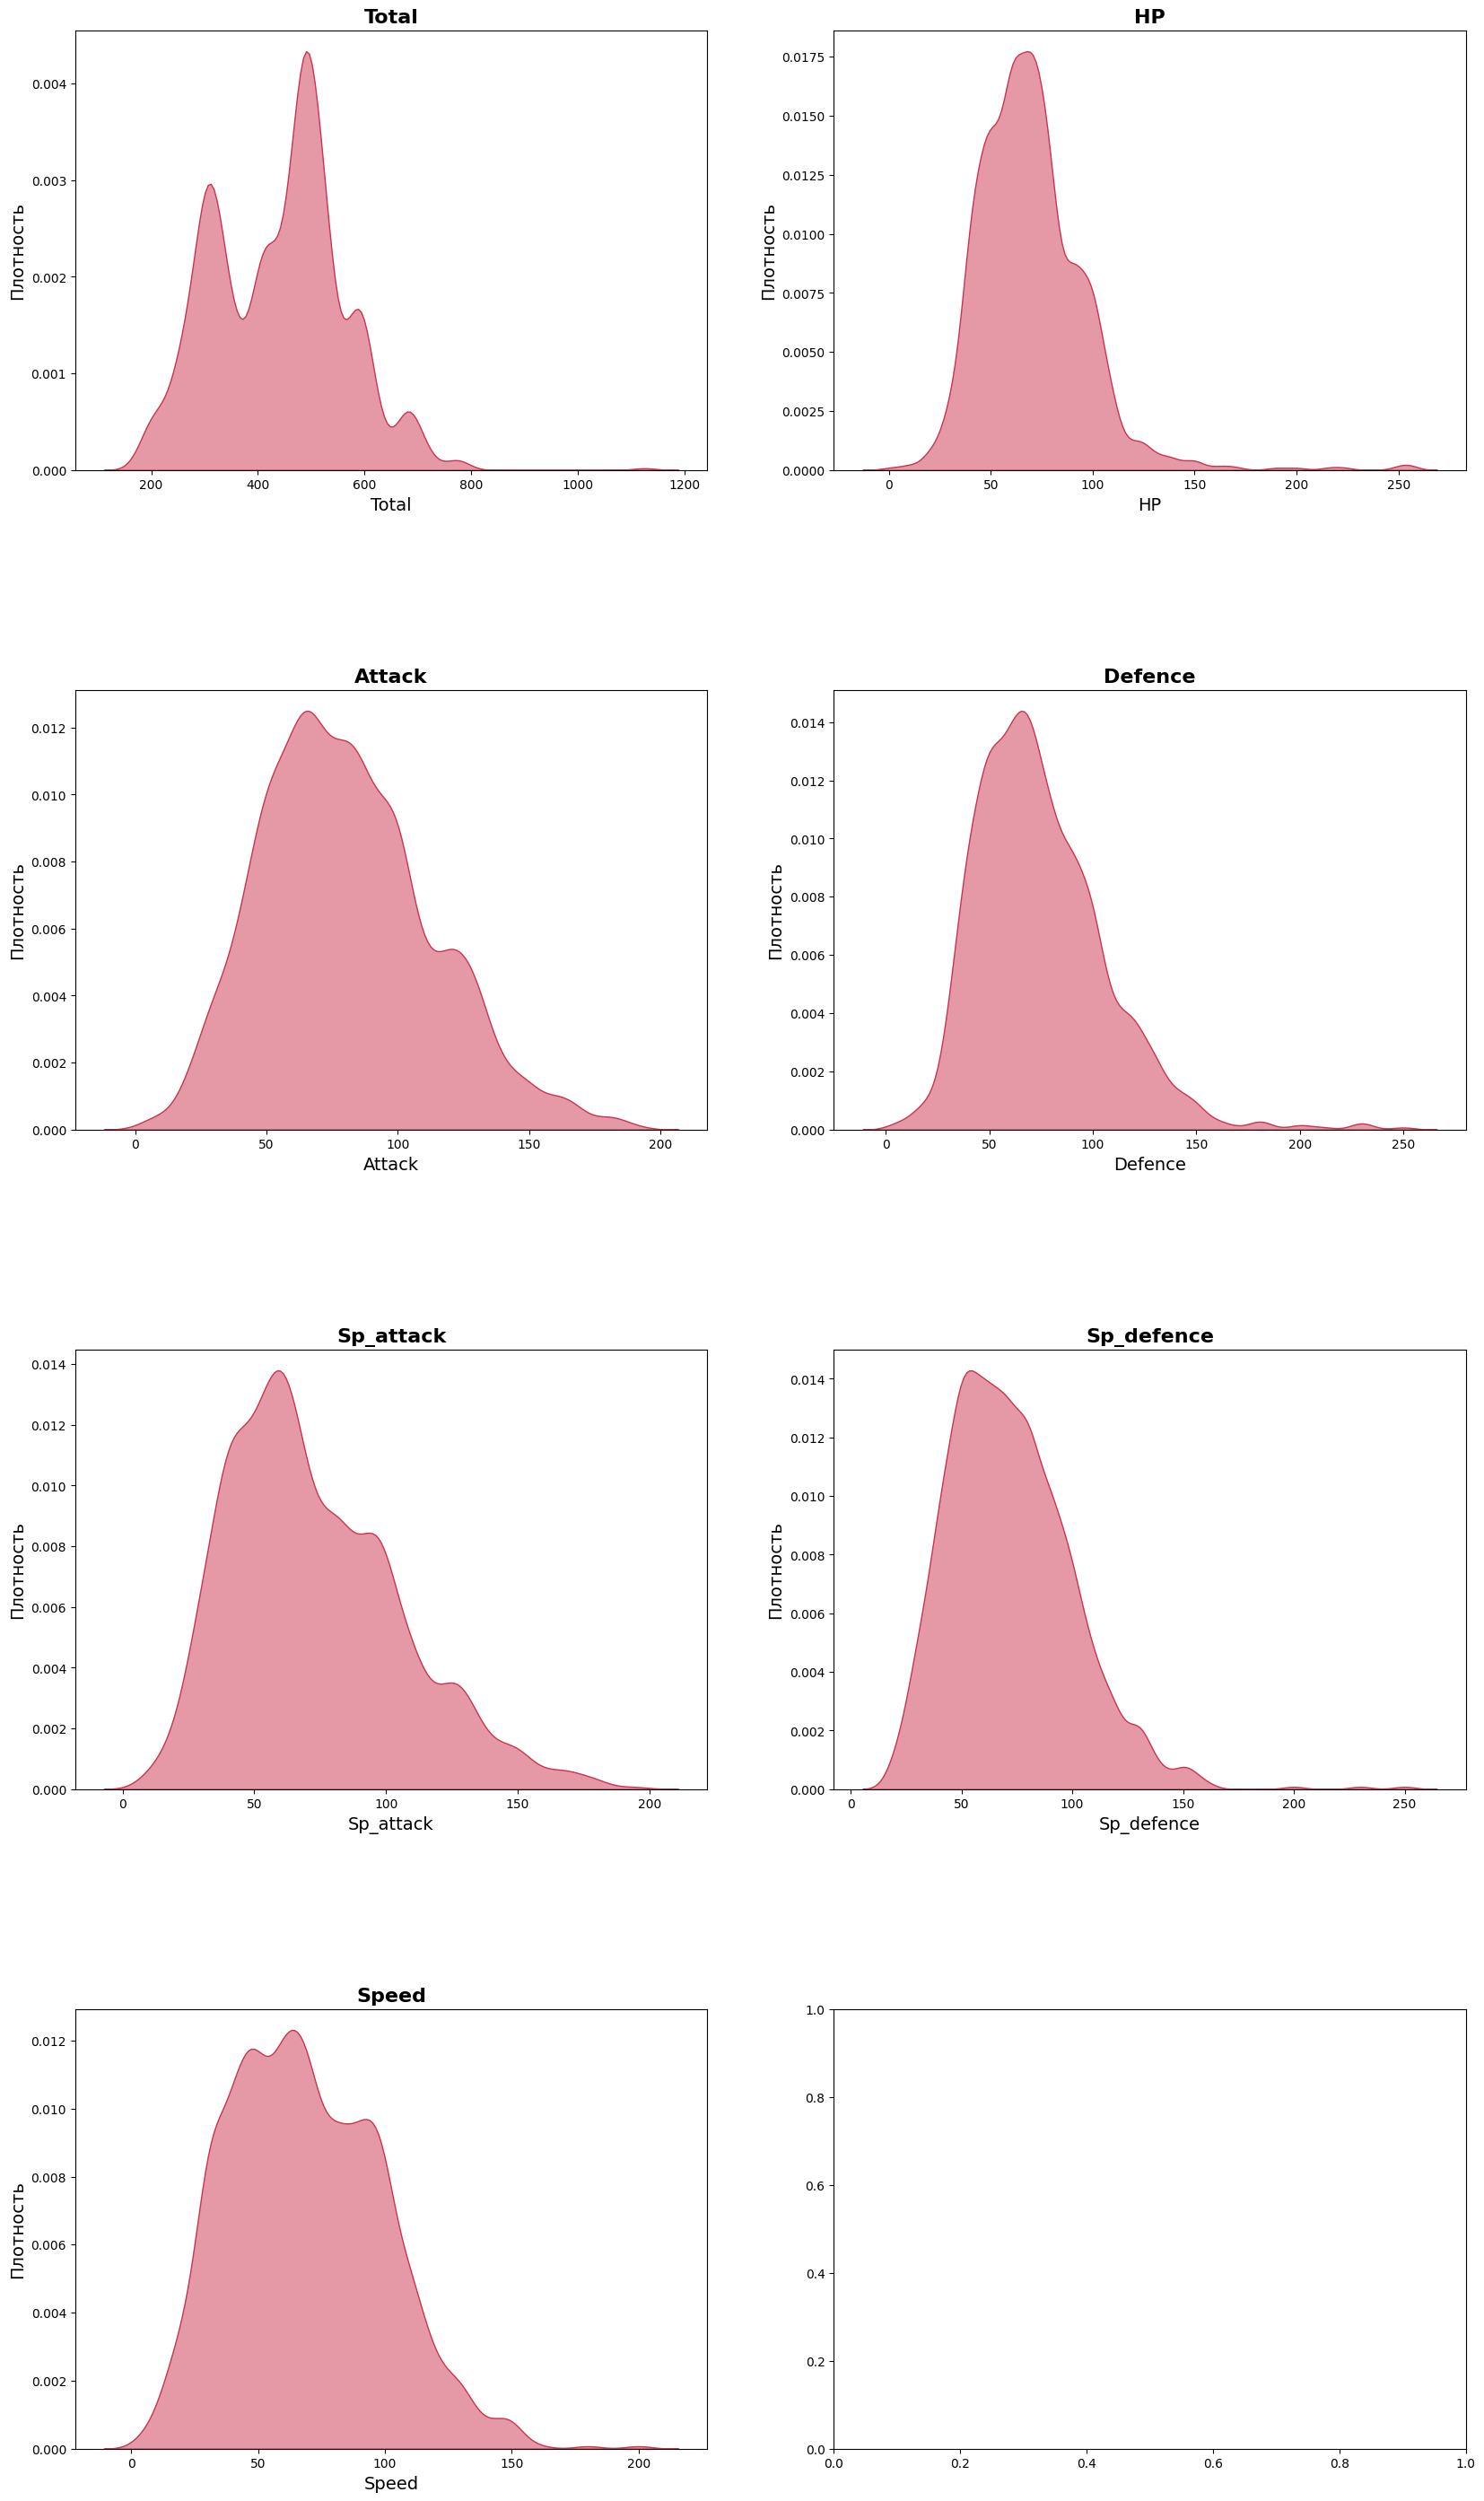

In [60]:
fig, axes = plt.subplots(4, 2, figsize = (20, 35))

plt.subplots_adjust(hspace=0.5)

columns = X.columns

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = X,
                x = column,
                fill = True,
                alpha = 0.5,
                bw_adjust=.7,
                color = [0.8, 0.2, 0.3],
                ax = ax)
    
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)
    

plt.show()

### Нормализация

In [105]:
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X), columns=X.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<h1 id="aa" style="color:black;background:#ffcc01;padding:8px;border-radius:8px;"> Метод главных компонет </h1>

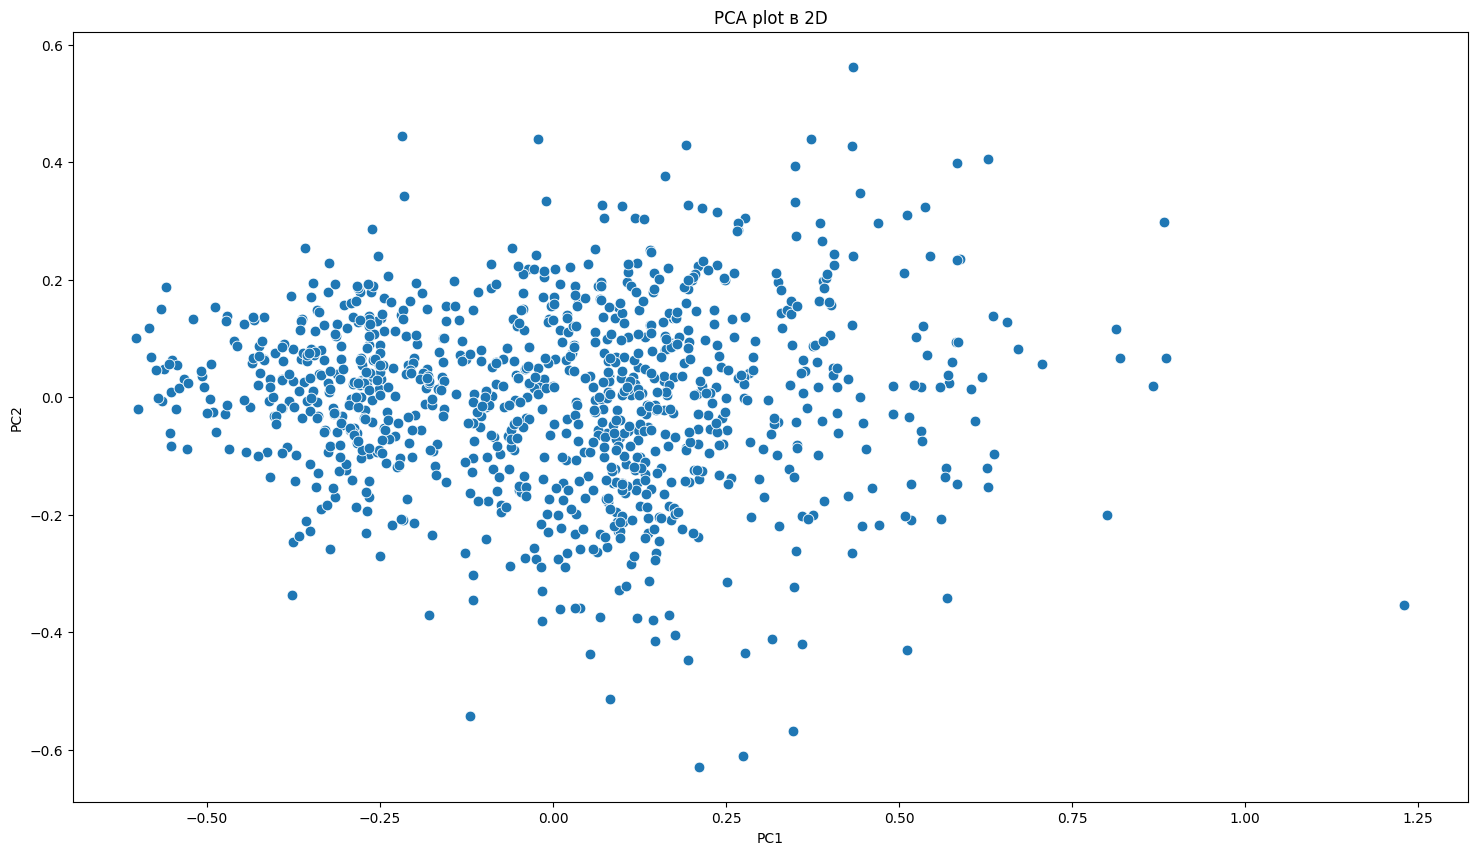

In [62]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))
    
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                s=60)

plt.title('PCA plot в 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [63]:
def TSNEplot(pred=None):    
    tsne = TSNE(random_state=1)

    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(18, 10))
    plt.scatter(X_tsne[:, 0], 
                X_tsne[:, 1], 
                c = pred, 
                edgecolor="none", 
                alpha=0.7, s=40,
        cmap=plt.cm.get_cmap("flare", 3))

    plt.colorbar()
    plt.title("t-SNE projection");

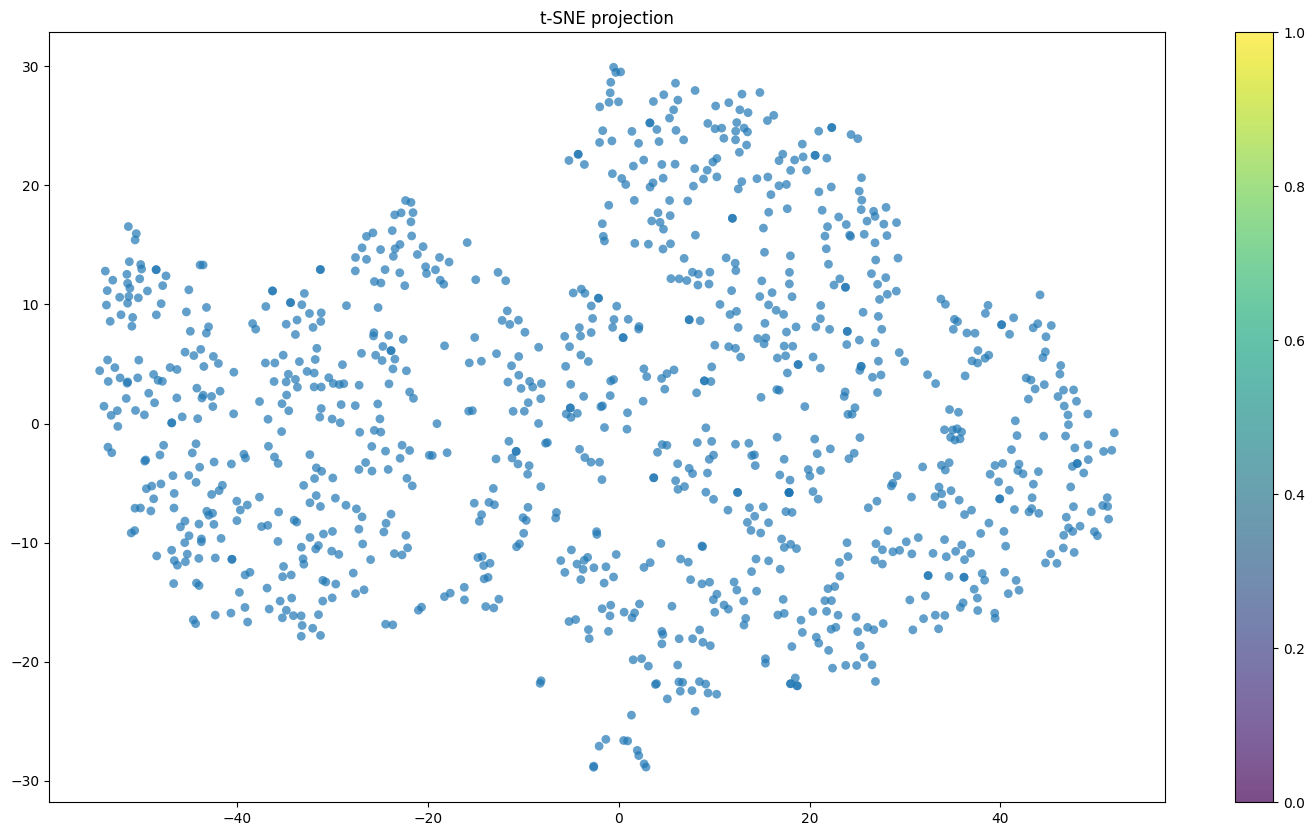

In [64]:
TSNEplot()

In [65]:
def PCAplot3D(x_data, y_data=None):
    components = PCA(n_components=3).fit_transform(x_data)

    fig = px.scatter_3d(
        components, 
        x=0, y=1, z=2, 
        color=y_data, 
        size=0.1*np.ones(len(X)), 
        opacity = 1,
        title='PCA plot in 3D',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width=1200, height=900
    )
    fig.show()

In [66]:
PCAplot3D(X)

<h1 id="aa" style="color:black;background:#ffcc01;padding:8px;border-radius:8px;"> Моделирование </h1>

# K-Means

In [67]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=3, random_state=1, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

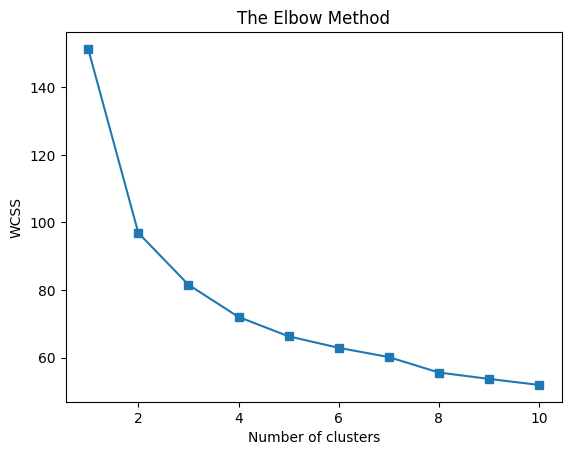

In [68]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss, marker="s")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [69]:
pca = PCA(n_components=2)


kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++')
kmeans.fit(X)

centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

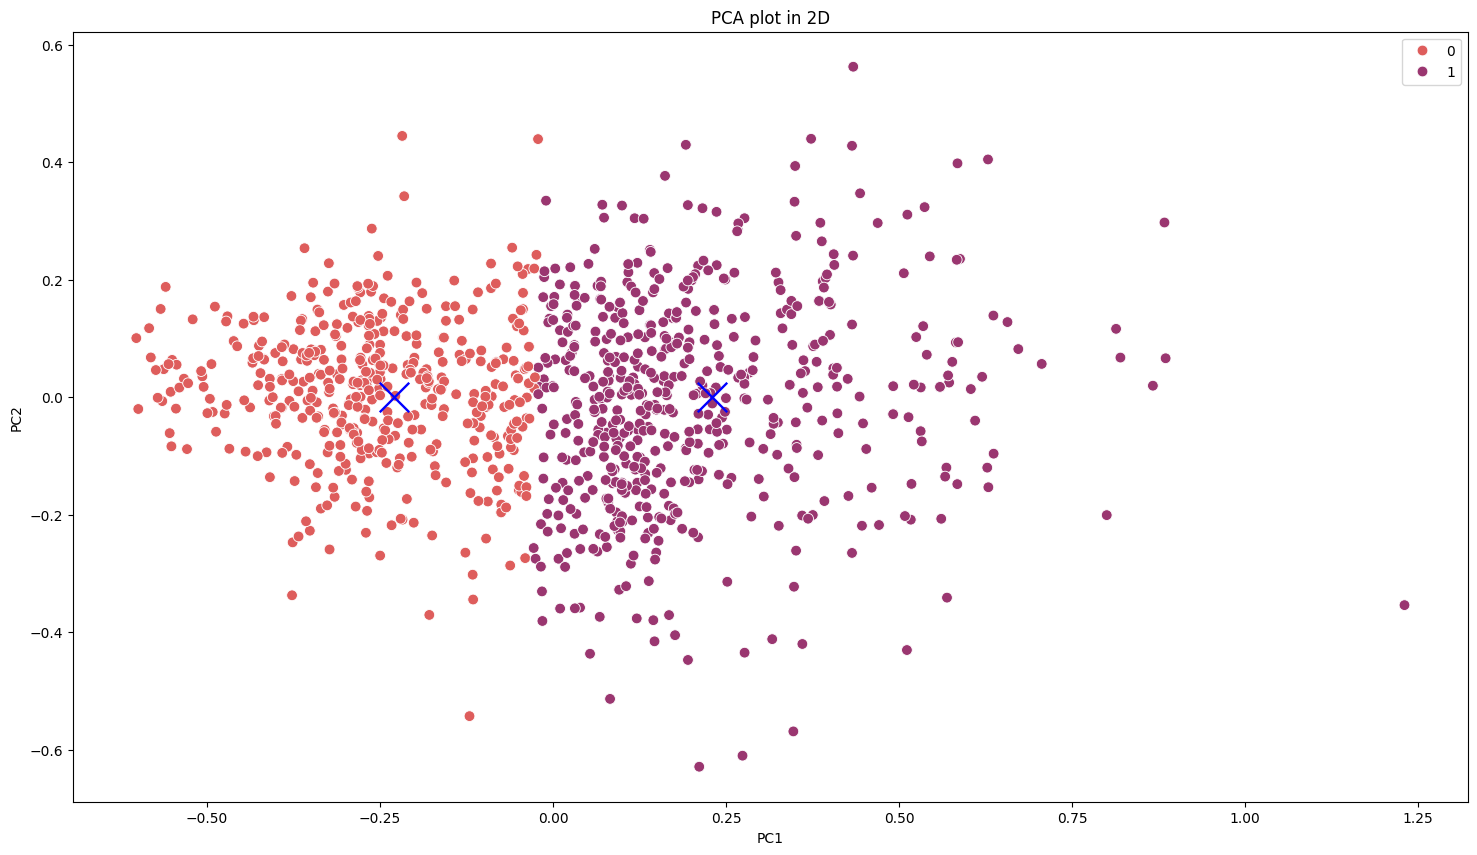

In [70]:
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_k, 
                palette="flare", 
                s=60)
sns.scatterplot(x = centroids_pca[:,0], 
                y =  centroids_pca[:,1],  
                marker="x", 
                s=450, 
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

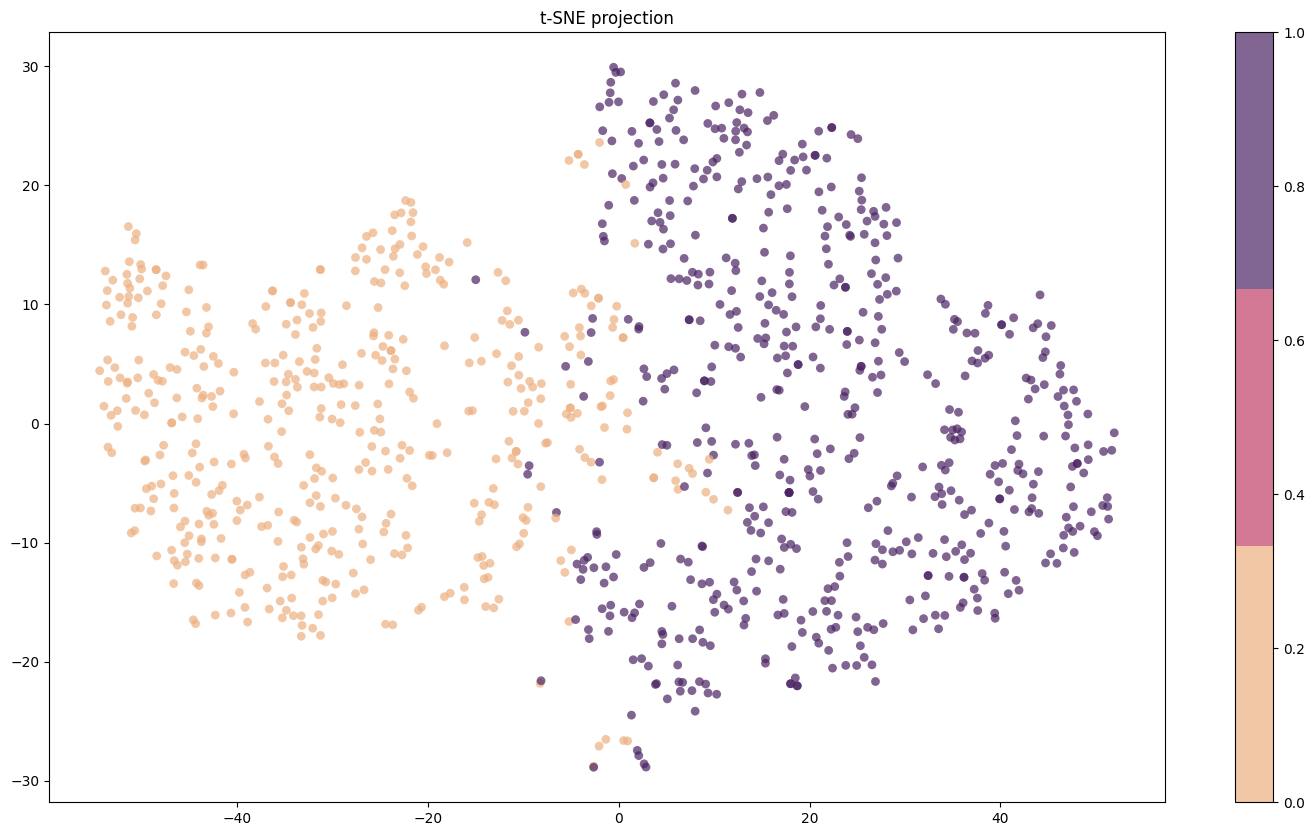

In [71]:
TSNEplot(pred_k)

In [72]:
PCAplot3D(X, pred_k)

# Agglomerative Clustering by Ward

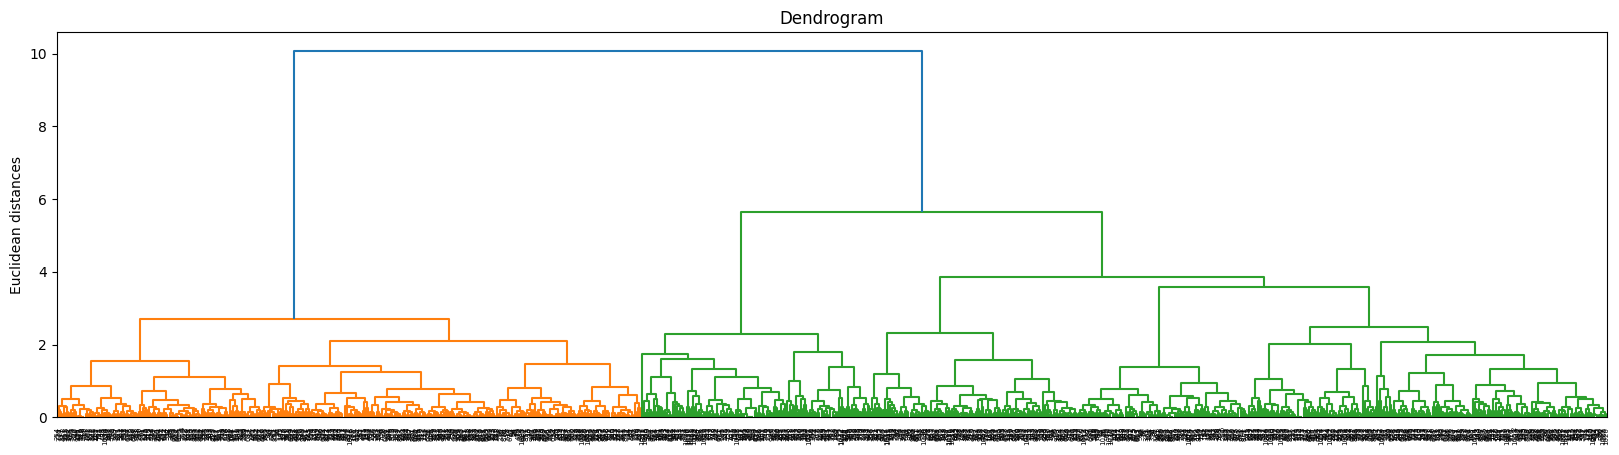

In [73]:
plt.figure(figsize=(20, 5))
# dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'), color_threshold = 3.9)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

In [74]:
# clustering_ward = AgglomerativeClustering(3).fit(X)
clustering_ward = AgglomerativeClustering(2).fit(X)
pred_ward = clustering_ward.labels_

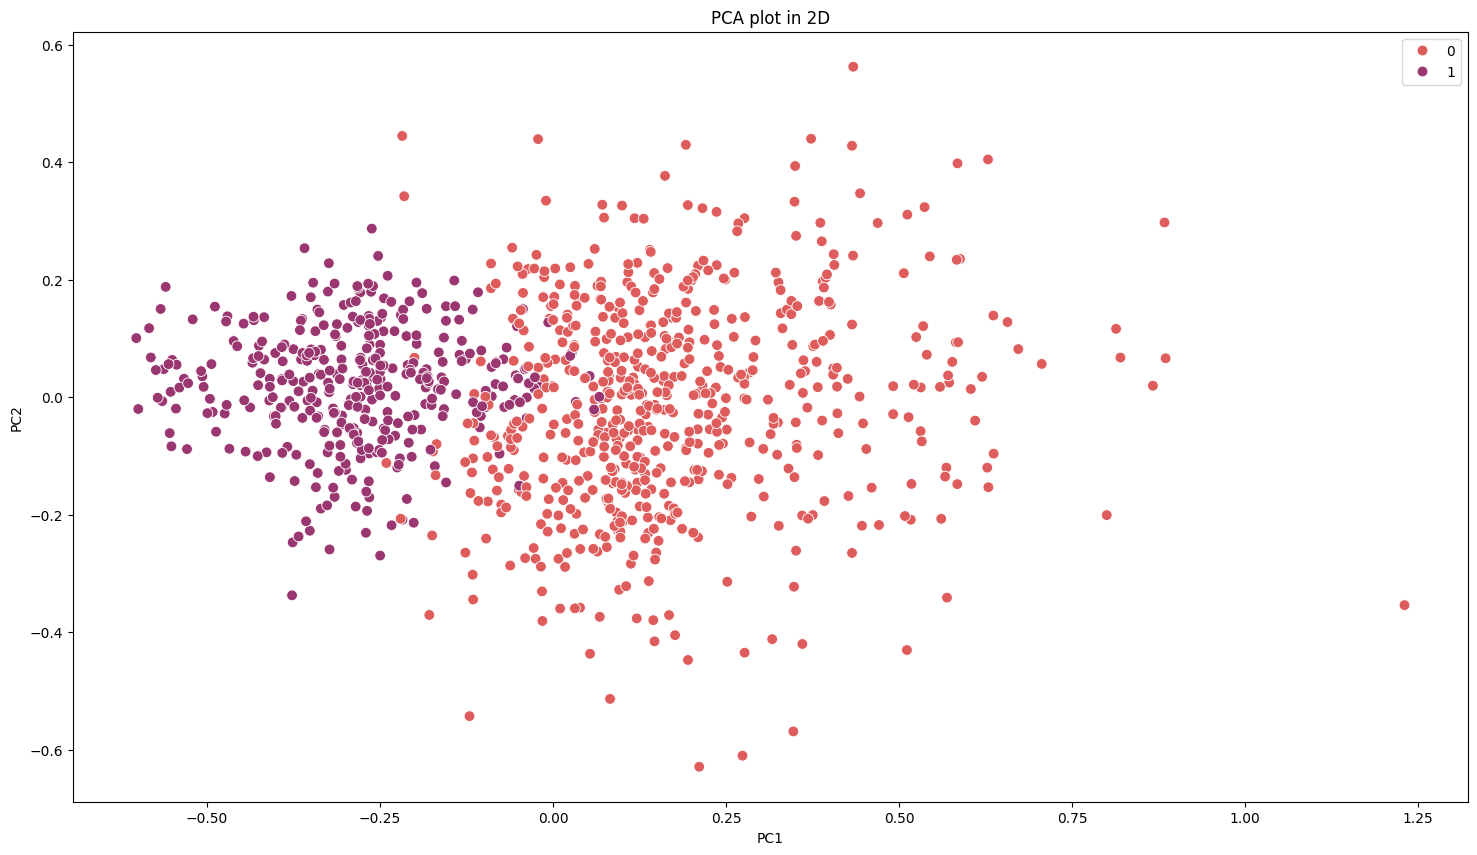

In [75]:
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_ward, 
                palette="flare", 
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

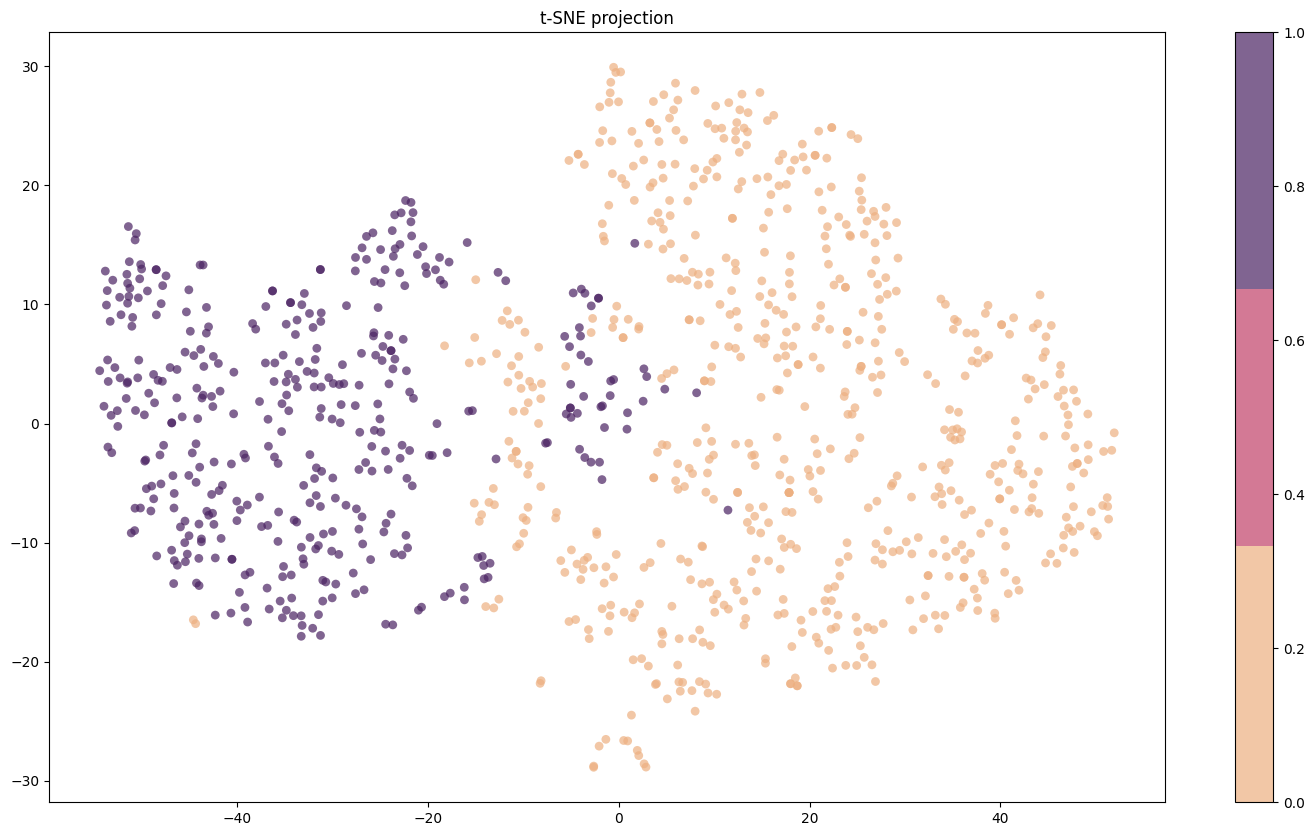

In [76]:
TSNEplot(pred_ward)

In [77]:
PCAplot3D(X, pred_ward)

# Spectral Clustering

In [78]:
# clustering_sp = SpectralClustering(3).fit(X)
clustering_sp = SpectralClustering(2).fit(X)
pred_sp = clustering_sp.labels_

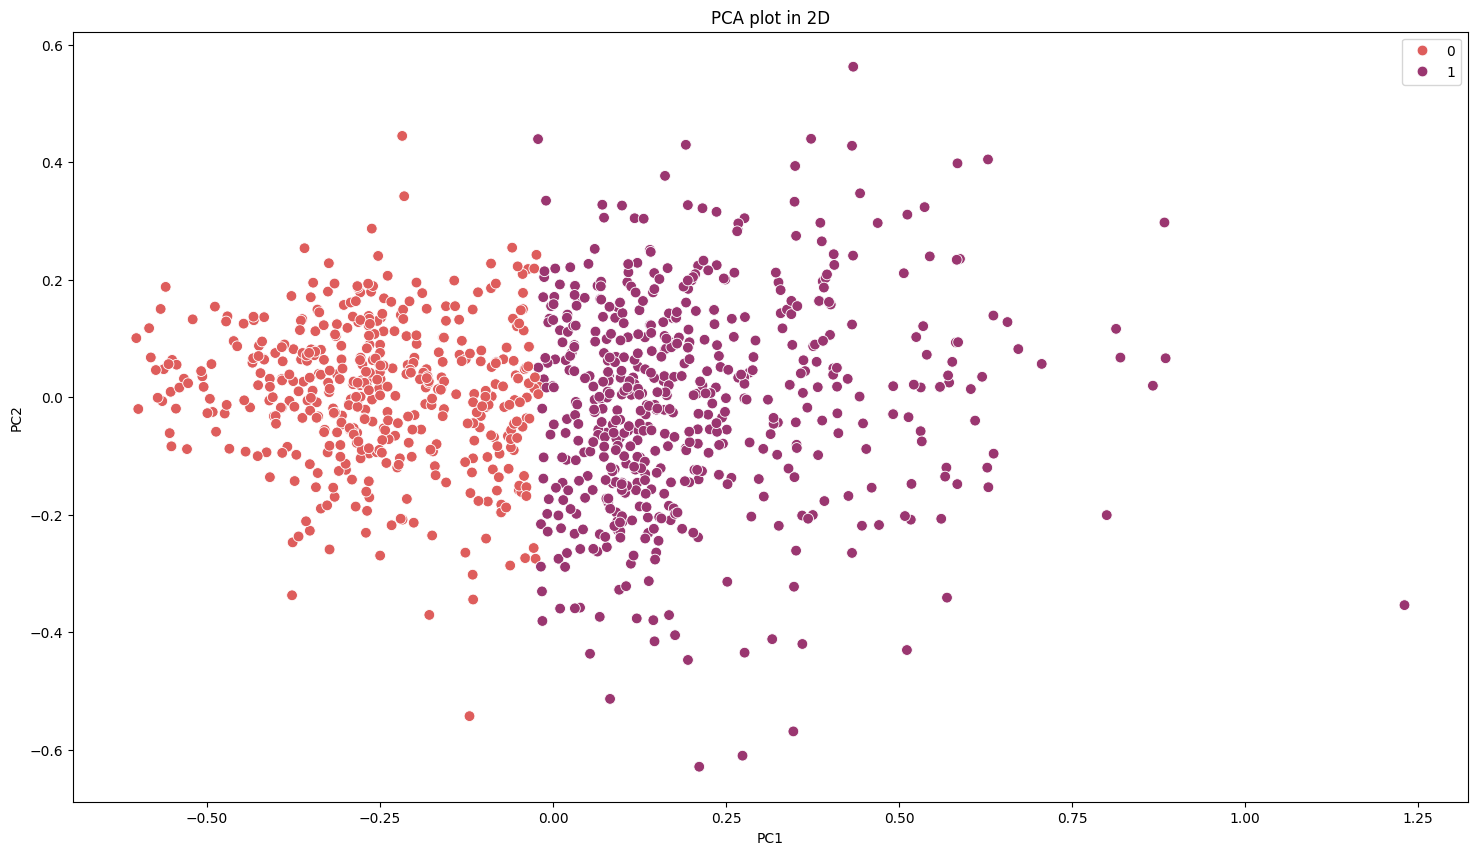

In [79]:
fig = plt.figure(figsize=(18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_sp, 
                palette="flare", 
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

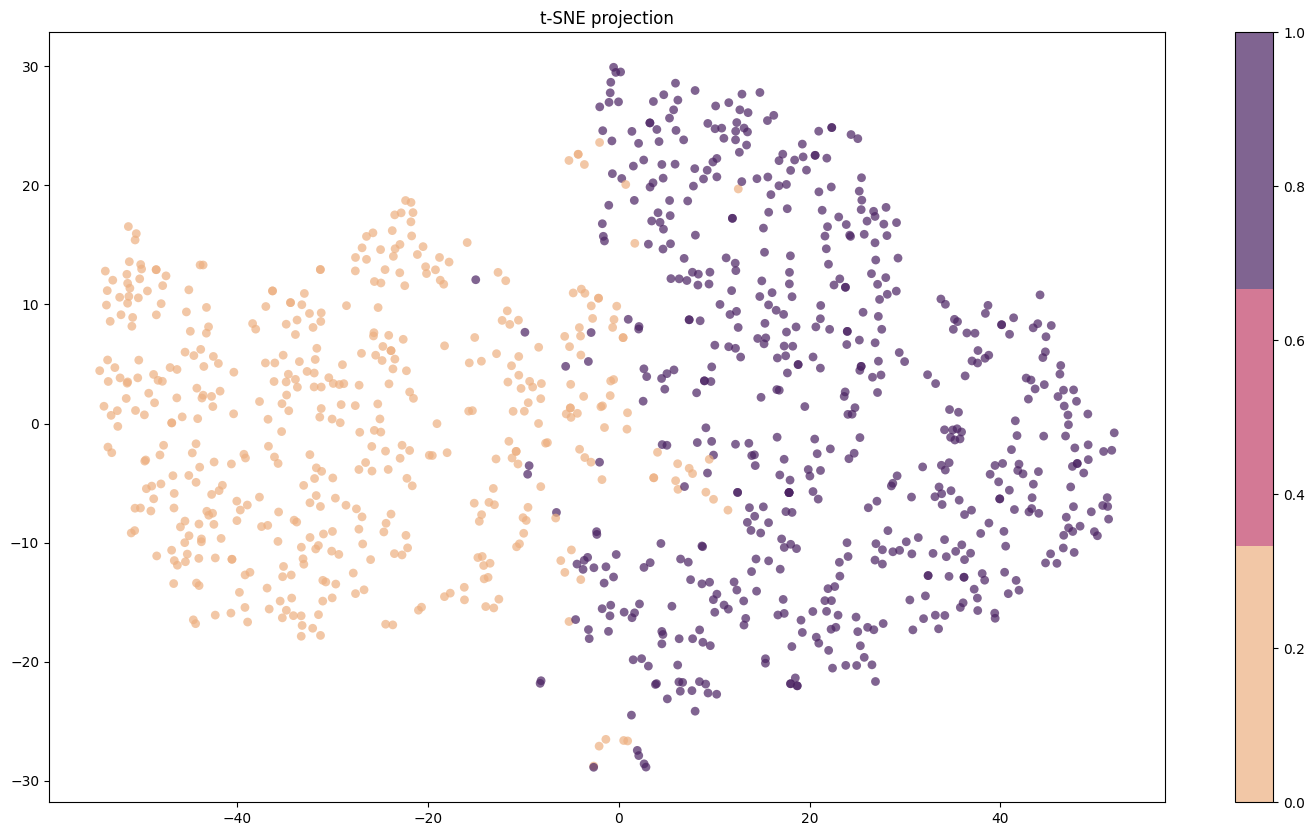

In [80]:
TSNEplot(pred_sp)

In [81]:
PCAplot3D(X, pred_sp)

<h1 id="aa" style="color:black;background:#ffcc01;padding:8px;border-radius:8px;"> Сравнение реальных и предсказанных кластеров </h1>

## Обзор целевой переменной

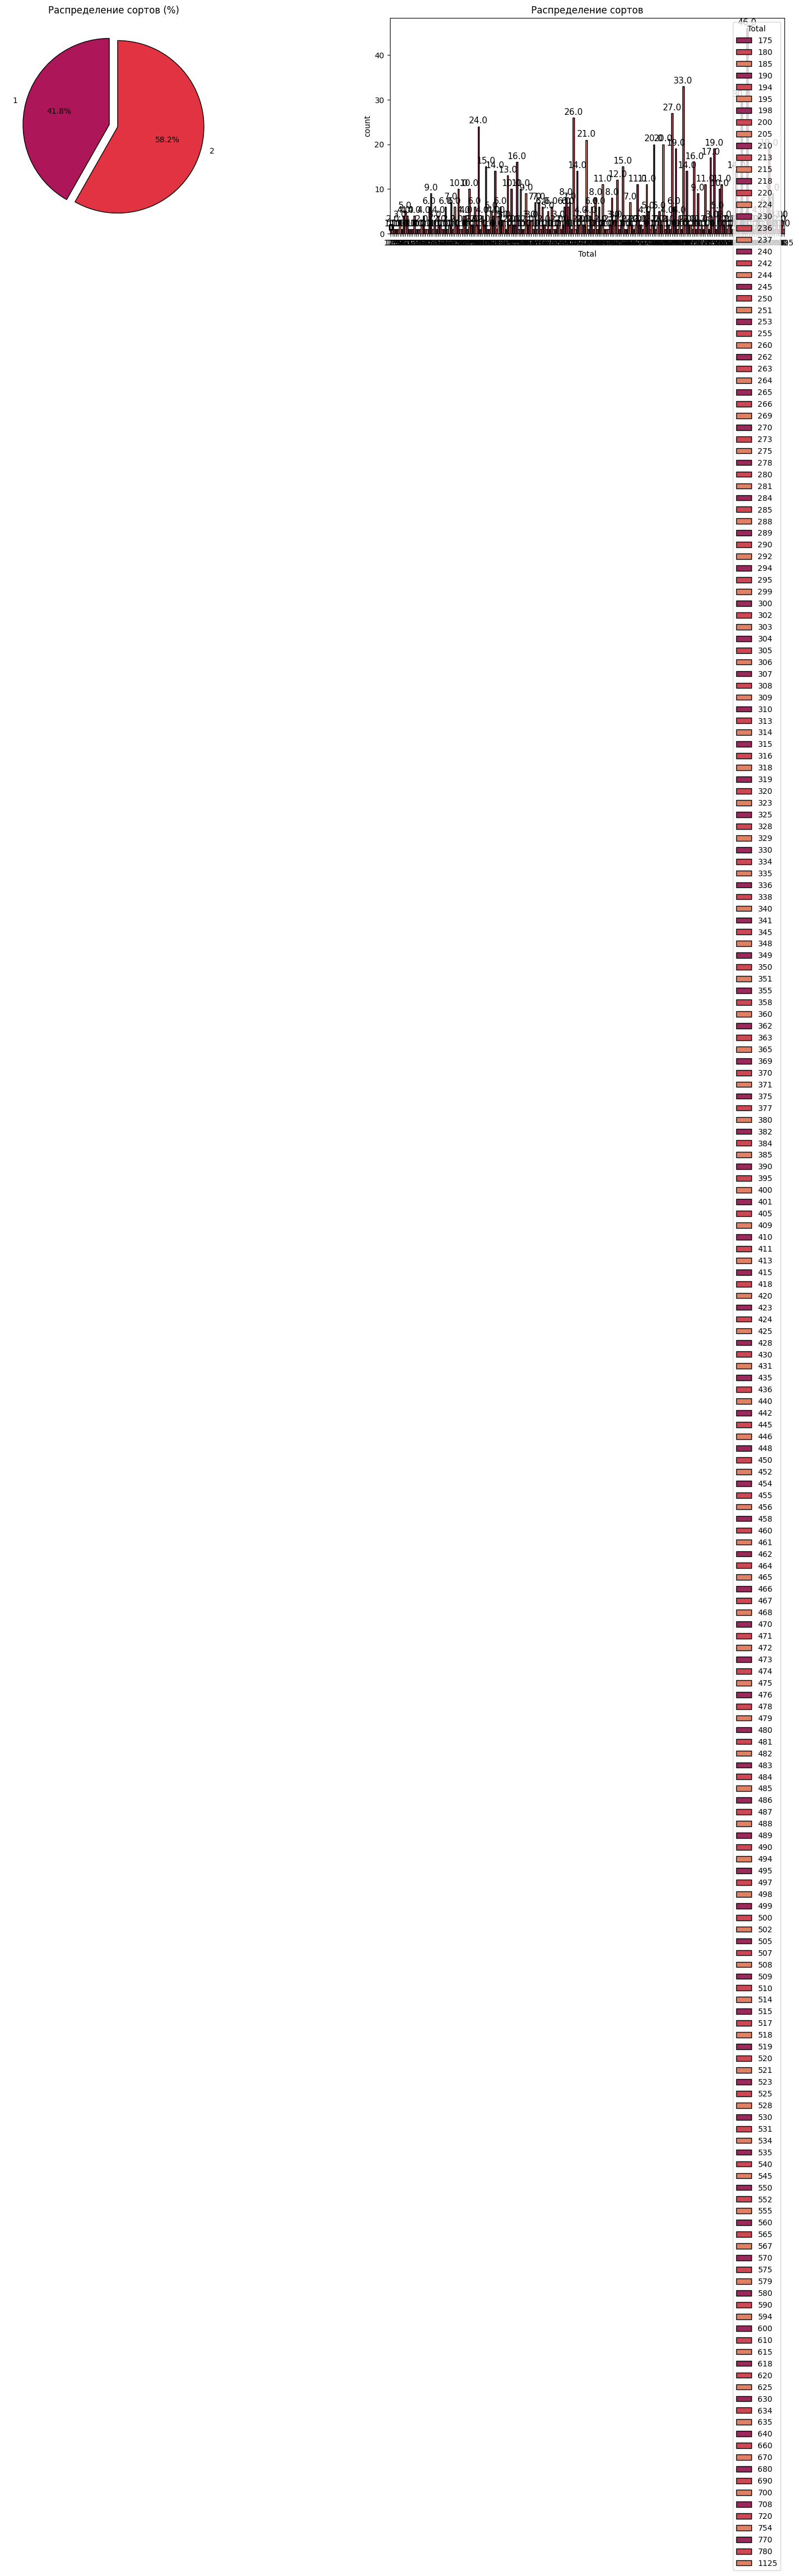

In [82]:
l = list(df['Total'].value_counts())
sumLenn = sum(l)
# proc = [l[1] / sumLenn * 100, l[0] / sumLenn * 100, l[2] / sumLenn * 100]
proc = [l[1] / sumLenn * 100, l[0] / sumLenn * 100]
colors1 = sns.color_palette("rocket")[2:5]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 5))
plt.subplot(1, 2, 1)
# plt.pie(proc, labels = ['1', '2', '3'], 
plt.pie(proc, labels = ['1', '2'],
        autopct = '%1.1f%%', 
        startangle = 90,
        # explode = (0.05,0.05, 0.05), 
        explode = (0.05,0.05), 
        colors = colors1, 
        wedgeprops = {'edgecolor' : 'black','antialiased' : True})
plt.title('Распределение сортов (%)')

plt.subplot(1, 2, 2)
ax = sns.countplot(x = df['Total'], 
                   hue = df['Total'], 
                   palette = colors1, 
                   edgecolor = "black" )
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.7,\
            rect.get_height() , horizontalalignment='center', fontsize = 11)
plt.title('Распределение сортов');

In [83]:
rs_k = rand_score(kmeans.labels_, y) 
rs_ward = rand_score(pred_ward, y)
rs_sp = rand_score(pred_sp, y)

print('\nK-Means')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n\n\n\n".format(rs_k, rs_k * 1045))


print('Agglomerative Clustering')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n\n\n\n".format(rs_ward, rs_ward * 1045))


print('Spectral Clustering')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n".format(rs_sp, rs_sp * 1045))


K-Means
_____________________________________________

 rand_score = 0.4944416946231828 

 516.6915708812261 из 1045 предсказано верно 




Agglomerative Clustering
_____________________________________________

 rand_score = 0.470232268235898 

 491.3927203065134 из 1045 предсказано верно 




Spectral Clustering
_____________________________________________

 rand_score = 0.49505765458578527 

 517.3352490421456 из 1045 предсказано верно 

